# Libraries

In [1]:
import os
import glob
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# 3. Model Building

## 3.1. Data loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/CARTO/data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load data
taxi_df = pd.read_csv("taxi_data_cleaned.csv")
# Visualize data
taxi_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pu_hour,do_hour,peak_hour,pu_day,do_day,trip_car
0,2,2017-03-09 21:30:11,2017-03-09 21:44:20,1.0,4.06,1,N,148,48,1,14.0,0.5,0.5,3.06,0.0,0.3,18.36,849.0,22,22,False,3,3,0
1,2,2017-03-09 22:01:08,2017-03-09 22:11:16,1.0,2.27,1,N,79,162,1,10.0,0.5,0.5,2.82,0.0,0.3,14.12,608.0,23,23,False,3,3,0
2,2,2017-03-09 22:16:05,2017-03-10 06:26:11,1.0,3.86,1,N,237,41,1,12.0,0.5,0.5,3.99,0.0,0.3,17.29,29406.0,23,7,False,3,4,0
3,1,2017-03-01 00:00:00,2017-03-01 00:14:22,1.0,2.80,1,N,261,79,1,12.5,0.5,0.5,1.00,0.0,0.3,14.80,862.0,1,1,False,2,2,0
4,1,2017-03-01 00:00:00,2017-03-01 00:19:30,1.0,6.00,1,N,87,142,1,19.5,0.5,0.5,3.50,0.0,0.3,24.30,1170.0,1,1,False,2,2,0


## 3.2. Data preparing

In [4]:
# Select variables to use a regressor
taxi_df_mod = taxi_df[['passenger_count','trip_distance','duration','trip_car','PULocationID','DOLocationID',
                   'fare_amount','extra','mta_tax','tip_amount', 'tolls_amount',
                   'total_amount','pu_hour','do_hour','peak_hour','pu_day','do_day']]

In [5]:
# Define categorical variables
categorical_variables = ['trip_car','pu_hour','do_hour','peak_hour','pu_day','do_day']

In [6]:
# Redefine categorical variables
for field in categorical_variables:
  taxi_df_mod[field] = taxi_df_mod[field].astype('category',copy=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
# Divide data in dependent variable and covariates
y = taxi_df_mod['tip_amount']
x = taxi_df_mod[['passenger_count','trip_distance','duration','trip_car','PULocationID','DOLocationID',
                   'fare_amount','extra','mta_tax', 'tolls_amount',
                   'total_amount','pu_hour','do_hour','peak_hour','pu_day','do_day']]

In [8]:
# Apply encoding to categorical variables
x = pd.get_dummies(data = x)

In [9]:
# Check types
x.dtypes

passenger_count    float64
trip_distance      float64
duration           float64
PULocationID         int64
DOLocationID         int64
                    ...   
do_day_2             uint8
do_day_3             uint8
do_day_4             uint8
do_day_5             uint8
do_day_6             uint8
Length: 76, dtype: object

In [10]:
del taxi_df_mod
del taxi_df

In [11]:
# Slit data in test and training data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)

In [12]:
del x
del y

In [13]:
# Check dimensions
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10633083, 76)
(2658271, 76)
(10633083,)
(2658271,)


# 3.3. Multiple Linear regression

In our data exploration and summary, we already found that most of the variables correlate directly with the tip amount. Likewise, we analyzed the influence of space and time in the tip amount, and we discovered that the variable is strongly affected by these. However, in space, we have the change of support problem, in which we can not aggregate the points to predict the tip amount per new york zones. The prediction of the tip amount must be performed per each trip and not per zone.  We already derived some variables such as day and hour of both pick up and drop off times in time. According to our exploratory analysis, these two variables might explain the tip amount.

Since using a Spatio-temporal model does not look like a realistic option, and considering, the amount of data we want to use for training our model, we will initially use a powerfull but straightforward model: an ordinary least squares (OLS) regression. 

But why a linear regression model instead of more sophisticated statistics models (spatial autoregressive models, general mixed linear models, geographically weighted regression, conditional autoregressive models), or even machine learning approaches (deep neural networks, random forest, decision tree model)?

In regression problems, often, the most straightforward answer is the correct one. As our data exhibit strong linear relationships, an OLS regression could indeed explain it. If an OLS regression is not enough to predict the tip amount, at least we will identify the significance and importance of the variables. This will be useful for applying other models.

So, let's start with a basic regression and hope it works!


In [14]:
# Define and train regressor
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
# Check coeffcients parameters
coeff_parameter = pd.DataFrame(model.coef_,X_train.columns,columns=['Coefficient'])
coeff_parameter

,Coefficient
passenger_count,-1.041973e-03
trip_distance,2.239076e-04
duration,-1.881895e-08
PULocationID,8.247648e-06
DOLocationID,7.639257e-06
...,...
do_day_2,-5.606184e-05
do_day_3,7.175315e-04
do_day_4,1.498705e-03
do_day_5,1.305286e-03


In [16]:
# Predict unseen data
predictions = model.predict(X_test)
predictions

array([2.65590486, 2.04512928, 1.00003516, ..., 7.30659996, 3.64708474,
       1.64696933])

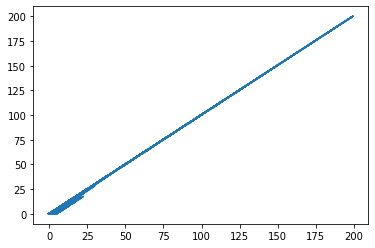

In [22]:
# test data vs predictions
plt.plot(predictions, y_test)

It looks excellent! Our model was able to predict the tip amount based on the covariates we chose. 

Let's corroborate our visual conclusion with some statistics.

In [21]:
# Linear model for test data
X_test_Sm= sm.add_constant(X_test)
ls=sm.OLS(y_test,X_test_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.405e+07
Date:                Tue, 27 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:02:10   Log-Likelihood:             2.1568e+06
No. Observations:             2658271   AIC:                        -4.314e+06
Df Residuals:                 2658201   BIC:                        -4.313e+06
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1307      0.002    -

Yes, our model predicts correctly 99% of the observations. We see that some variables are more important than other, and , that we can remove many since they are not contributing much.

In [25]:
rms = mean_squared_error(y_test, predictions, squared=False)
rms

0.107497417591097

The values are great, and it seems that we can now predict the tip amount. Howveer, a R2 values of almost 100 is very unlikely. 

Let's try another approach: a ramdom forest regressor.

# 3.2. Random forest regression

So our OLS regression works very well, but it looks too overconfident. If a complex regressor like random forest displays a similar accuracy to OLS regression, then we can trust this latter.  

Let's try!


In [ ]:
# Random Forest regression
regressor = RandomForestRegressor(n_estimators = 256, random_state = 0)
regressor.fit(X_train,y_train)

In [ ]:
predictions_rf = regressor.predict(X_test)
predictions_rf

In [ ]:
plt.plot(predictions_rf, y_test)

# Summary

We could predict the tips in the NYC  yellow taxis with an accuracy of 71.74% using OLS regression and XXXX using random forest. Both methods showed good performance, and minor problems were faced when modeling the data. 

We should emphasize how essential data cleaning and data exploration are.  It took almost 90% of the time. Good data is equal to good results. Furthermore, many analyses can be performed on this dataset, and more complex models (and also exploratory techniques) can apply to this rich data.


## Limitations

*   No extra information about the trips. We believed that good results could also be obtained using variables related to the passengers since giving a tip depends mainly on the taxi users. Having this information can reduce the number of variables needed for our models. Likewise, information about the traffic, other vehicles, and even environmental variables!
*   The amount of data is massive, and we only used information for three months. Most models require millions and millions of records to identify trends and correctly model any given variable. The computational cost is enormous. Most of the visualization, analyses, and models of this brief study used many of my laptop resources (especially the models.)
*   Using data from many years to identify temporal short and long-term trends!





## Further Work

*   Spatio-temporal model if coordinates of pick-ups and drop-offs are provided. There is enough temporal information in the data sets.
*   Categorical model if tips can be encoded as discrete values.
*   Predicting other exciting variables such as the possible number of passengers or the location and time in which a user will need a cab!




## API

*   data: The API would provide data. Although the taxi in NYC is available, it has many errors and noise. We will provide a clean dataset ready to use. Also, we will offer the user an easy-to-use and customizable way to access considerable amounts of data. Perhaps, the user only wants a couple of records and not the entire data set!
*   models: The API would provide multiple models. We will share the trained models to obtain predictions with its data or the data from the API itself. We can as well offer models ready to train if the users need so.
*  visualizations: The API would provide visualizations. Since a significant portion of data analysis comprises data visualization, we will supply the user with numerous visualizations. From bar charts to maps, we will facilitate the user's understanding of the data, and we will encourage him to create new ones.





